In [24]:

!pip install pandas matplotlib requests openpyxl fredapi yfinance --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.3
    Uninstalling protobuf-4.24.3:
      Successfully uninstalled protobuf-4.24.3
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.58
    Uninstalling yfinance-0.2.58:
      Successfully uninstalled yfinance-0.2.58


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from fredapi import Fred
import datetime


In [26]:
fred = Fred(api_key="ab4496cc25fcb3f3b2307171fe0e13eb")

In [27]:
url = "http://www.econ.yale.edu/~shiller/data/ie_data.xlsx"
url="https://img1.wsimg.com/blobby/go/e5e77e0b-59d1-44d9-ab25-4763ac982e53/downloads/02d69a38-97f2-45f8-941d-4e4c5b50dea7/ie_data.xls?ver=1743773003799"
response = requests.get(url)
xls = pd.ExcelFile(BytesIO(response.content))


In [28]:

# Parse relevant sheet
df = xls.parse("Data", skiprows=7)
df.head()



,Date,P,D,E,CPI,Fraction,Rate GS10,Price,Dividend,Price.1,...,CAPE,Unnamed: 13,TR CAPE,Unnamed: 15,Yield,Returns,Returns.1,Real Return,Real Return.1,Returns.2
0,1871.01,4.44,0.26,0.4,12.464061,1871.041667,5.32,114.041699,6.678118,114.041699,...,NaN,NaN,NaN,NaN,NaN,1.004177,1.000000,0.130609,0.092504,0.038106
1,1871.02,4.5,0.26,0.4,12.844641,1871.125000,5.323333,112.158144,6.480248,112.698164,...,NaN,NaN,NaN,NaN,NaN,1.004180,0.974424,0.130858,0.094635,0.036224
2,1871.03,4.61,0.26,0.4,13.034972,1871.208333,5.326667,113.222074,6.385627,114.301915,...,NaN,NaN,NaN,NaN,NaN,1.004183,0.964209,0.130951,0.096186,0.034765
3,1871.04,4.74,0.26,0.4,12.559226,1871.291667,5.33,120.824701,6.627515,122.534612,...,NaN,NaN,NaN,NaN,NaN,1.004185,1.004919,0.122056,0.090972,0.031084
4,1871.05,4.86,0.26,0.4,12.273812,1871.375000,5.333333,126.764339,6.781631,129.131441,...,NaN,NaN,NaN,NaN,NaN,1.004188,1.032591,0.122638,0.089488,0.033150


In [29]:

#df = df.rename(columns={"Date": "YearMonth", "CAPE": "CAPE", "Real Price": "Price"})
df = df[["Date", "CAPE", "Price"]].dropna()
df.head()

,Date,CAPE,Price
120,1881.01,18.473952,210.381126
121,1881.02,18.147258,207.603938
122,1881.03,18.270119,209.959250
123,1881.04,17.950108,207.215490
124,1881.05,18.869719,218.707552


In [30]:
# Convert to datetime
#df["Date"] = pd.to_datetime(df["Date"], format='%Y.%m', errors='coerce')
df = df.dropna(subset=["Date"])
df.set_index("Date", inplace=True)
df.head()


,CAPE,Price
Date,,
1881.01,18.473952,210.381126
1881.02,18.147258,207.603938
1881.03,18.270119,209.959250
1881.04,17.950108,207.215490
1881.05,18.869719,218.707552


In [31]:
# Keep monthly CAPE
cape_df = df[["CAPE"]].copy()
cape_df = cape_df[cape_df.index >= 1962.01 ]  # Aligns with treasury data
cape_df.head()
print(cape_df.index)

Index([1962.01, 1962.02, 1962.03, 1962.04, 1962.05, 1962.06, 1962.07, 1962.08,
       1962.09,  1962.1,
       ...
       2024.07, 2024.08, 2024.09,  2024.1, 2024.11, 2024.12, 2025.01, 2025.02,
       2025.03, 2025.04],
      dtype='float64', name='Date', length=760)


In [32]:
# Fetch DGS10 (10-Year Treasury yield) - daily, back to 1962
yield_data = fred.get_series("DGS10", observation_start=datetime.datetime(1962, 1, 1))

# Convert to DataFrame and resample to monthly average
yield_df = yield_data.to_frame(name="10Y_Yield")
yield_df.index = pd.to_datetime(yield_df.index)

#yield_df.index = yield_df.index.strftime('%Y.%m')

monthly_yields = yield_df.resample('ME').mean()

monthly_yields.index = monthly_yields.index.strftime('%Y.%m')
monthly_yields.index = monthly_yields.index.astype('float64')
monthly_yields.head()
print(monthly_yields.index)

Index([1962.01, 1962.02, 1962.03, 1962.04, 1962.05, 1962.06, 1962.07, 1962.08,
       1962.09,  1962.1,
       ...
       2024.08, 2024.09,  2024.1, 2024.11, 2024.12, 2025.01, 2025.02, 2025.03,
       2025.04, 2025.05],
      dtype='float64', length=761)


In [33]:
merged_df = pd.merge(cape_df, monthly_yields, left_index=True, right_index=True)
merged_df.head()

merged_df.dropna(inplace=True)
merged_df.head()


,CAPE,10Y_Yield
1962.01,21.197931,4.083182
1962.02,21.451688,4.039444
1962.03,21.443159,3.930455
1962.04,20.658336,3.843000
1962.05,19.089367,3.873636


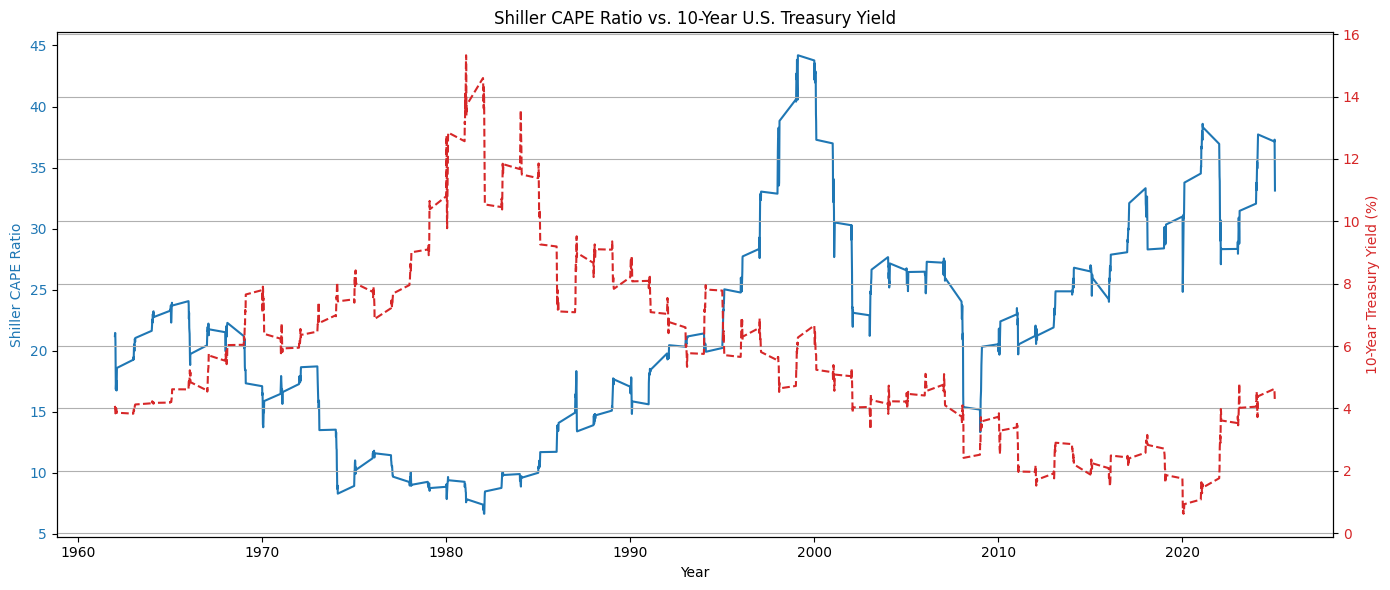

In [42]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# CAPE on left Y-axis
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Shiller CAPE Ratio', color=color)
ax1.plot(merged_df.index, merged_df['CAPE'], color=color, label='CAPE')
ax1.tick_params(axis='y', labelcolor=color)

# 10-Year Yield on right Y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('10-Year Treasury Yield (%)', color=color)
ax2.plot(merged_df.index, merged_df['10Y_Yield'], color=color, linestyle='--', label='10Y Yield')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Shiller CAPE Ratio vs. 10-Year U.S. Treasury Yield")
fig.tight_layout()
plt.grid(True)
plt.show()



In [43]:
import yfinance as yf  # For potentially getting S&P 500 data
from datetime import datetime, date
sp500_df = []
sp500_ticker = '^GSPC'  # S&P 500 ticker
date_str = str(merged_df.index[0])
date_obj  = pd.to_datetime(date_str, format='%Y.%m')
start_date = date_obj.strftime('%Y-%m-01')
end_date = date.today()
sp500_df = yf.download(sp500_ticker, start=start_date, end=end_date, auto_adjust=True)
sp500_df = sp500_df['Close'].resample('ME').last().dropna()
sp500_monthly = pd.DataFrame(sp500_df)
sp500_monthly.rename(columns={'Close': 'SP500_Price'}, inplace=True)

sp500_monthly.index = sp500_monthly.index.strftime('%Y.%m')
sp500_monthly.index = sp500_monthly.index.astype('float64')
sp500_monthly.rename(columns={'^GSPC': 'SP500_Price'}, inplace=True)
print(sp500_monthly.index.name)

sp500_monthly.head()

[*********************100%***********************]  1 of 1 completed

Date


Ticker,SP500_Price
Date,
1962.01,68.839996
1962.02,69.959999
1962.03,69.550003
1962.04,65.239998
1962.05,59.630001


In [63]:
from functools import reduce
# Calculate approximate 10-year forward returns (simplified)
forward_returns = []
for i in range(len(sp500_monthly) - 121):  # Need at least 10 years (120 months) of future data
    start_price = sp500_monthly['SP500_Price'].iloc[i]
    start_date = sp500_monthly.index[i]
    end_price = sp500_monthly['SP500_Price'].iloc[i + 120]
    total_return = (end_price / start_price) ** (1/10) - 1
    forward_returns.append([start_date,total_return])

forward_returns_df = pd.DataFrame(forward_returns, columns=['Date','10Y_Forward_Return'])

forward_returns_df['10Y_Forward_Return'] *= 100 # Convert to percentage
#forward_returns_df.set_index('Date',inplace=True)
#forward_returns_df.head()
#forward_returns_df.index
#print("\nApproximate 10-Year Forward Returns:")
merged_df.index.name='Date'
merged_df.head()

data_frames = [merged_df, forward_returns_df]
new_merged_df = reduce(lambda left, right: pd.merge(left,right, on='Date', how='outer'), data_frames) # changed how to outer to include all rows
print("\nMerged DataFrame using reduce and outer join:")
new_merged_df.set_index("Date", inplace=True)
new_merged_df.head()


Merged DataFrame using reduce and outer join:


,CAPE,10Y_Yield,10Y_Forward_Return
Date,,,
1962.01,21.197931,4.083182,4.206351
1962.02,21.451688,4.039444,4.298609
1962.03,21.443159,3.930455,4.421460
1962.04,20.658336,3.843000,5.137604
1962.05,19.089367,3.873636,6.269057


In [64]:
import numpy as np
events = [
    #('1962-10-16', 'Cuban Missile Crisis', 'red'),
    ('1973-10-06', 'Yom Kippur War', 'red'),
    ( '1979-11-04', 'Iran Hostage Crisis', 'red'),
    ( '1987-10-19', 'Black Monday Stock Market Crash', 'red'),
    ( '1990-08-02', 'Iraq Invades Kuwait', 'red'),
    ( '2001-09-11', '9/11 Terrorist Attacks', 'red'),
    ( '2008-09-15', 'Lehman Brothers Collapse', 'red'),
    ( '2020-03-23', 'COVID-19 Market Crash', 'red'),
    ( '2020-11-03', 'US Presidential Election', 'blue'),
    ( '2021-01-06', 'US Capitol Riot', 'red'),
    ( '2021-03-11', 'US Stimulus Checks', 'green'),
    ( '2021-09-20', 'Evergrande Default Warning', 'red'),
    ( '2022-02-24', 'Russia-Ukraine War Begins', 'red'),
    ( '2022-06-15', 'US Interest Rate Hike', 'red'),
    ( '2022-11-08', 'Midterm Elections', 'blue'),
    ( '2023-03-10', 'Silicon Valley Bank Collapse', 'red'),
    ( '2023-06-01', 'US Debt Ceiling Crisis Resolved', 'green')
]
events = [
    #('1962-10-16', 'Cuban Missile Crisis', 'red'),
    ( 1973.10, 'Yom Kippur War', 'red'),
    ( 1979.11, 'Iran Hostage Crisis', 'red'),
    ( 1987.10, 'Black Monday Stock Market Crash', 'red'),
    ( 1990.08, 'Iraq Invades Kuwait', 'red'),
    ( 2001.09, '9/11 Terrorist Attacks', 'red'),
    ( 2008.09, 'Lehman Brothers Collapse', 'red'),
    ( 2020.03, 'COVID-19 Market Crash', 'red'),
    ( 2020.11, 'US Presidential Election', 'blue'),
    ( 2021.01, 'US Capitol Riot', 'red'),
    ( 2023.11, 'US Stimulus Checks', 'green'),
    ( 2021.09, 'Evergrande Default Warning', 'red'),
    ( 2022.02, 'Russia-Ukraine War Begins', 'red'),
    ( 2022.06, 'US Interest Rate Hike', 'red'),
    ( 2022.11, 'Midterm Elections', 'blue'),
    ( 2023.03, 'Silicon Valley Bank Collapse', 'red'),
    ( 2023.06, 'US Debt Ceiling Crisis Resolved', 'green')
]


event_df = pd.DataFrame(events, columns=['Date','Event','Color'])
event_df.head()


,Date,Event,Color
0,1973.10,Yom Kippur War,red
1,1979.11,Iran Hostage Crisis,red
2,1987.10,Black Monday Stock Market Crash,red
3,1990.08,Iraq Invades Kuwait,red
4,2001.09,9/11 Terrorist Attacks,red


In [65]:
 #Recession and recovery periods
recession_periods = [
    (1973.11, 1975.03),  # 1973-1975 Recession
    (1980.01, 1980.07),  # 1980 Recession
    (1981.07, 1982.11),  # 1981-1982 Recession
    (2001.03, 2001.11),  # 2001 Recession
    (2007.12, 2009.06)   # 2007-2009 Recession
]

recovery_periods = [
   # (np.datetime64('1933-03-01'), np.datetime64('1939-06-01')),  # The New Deal
    #(np.datetime64('1945-10-01'), np.datetime64('1950-12-31')),  # Post-World War II Recovery
    (1982.11, 1990.07),  # Reagan Era Recovery
    (2009.06, 2020.02)  # Recovery Following the 2007-2009 Recession
]


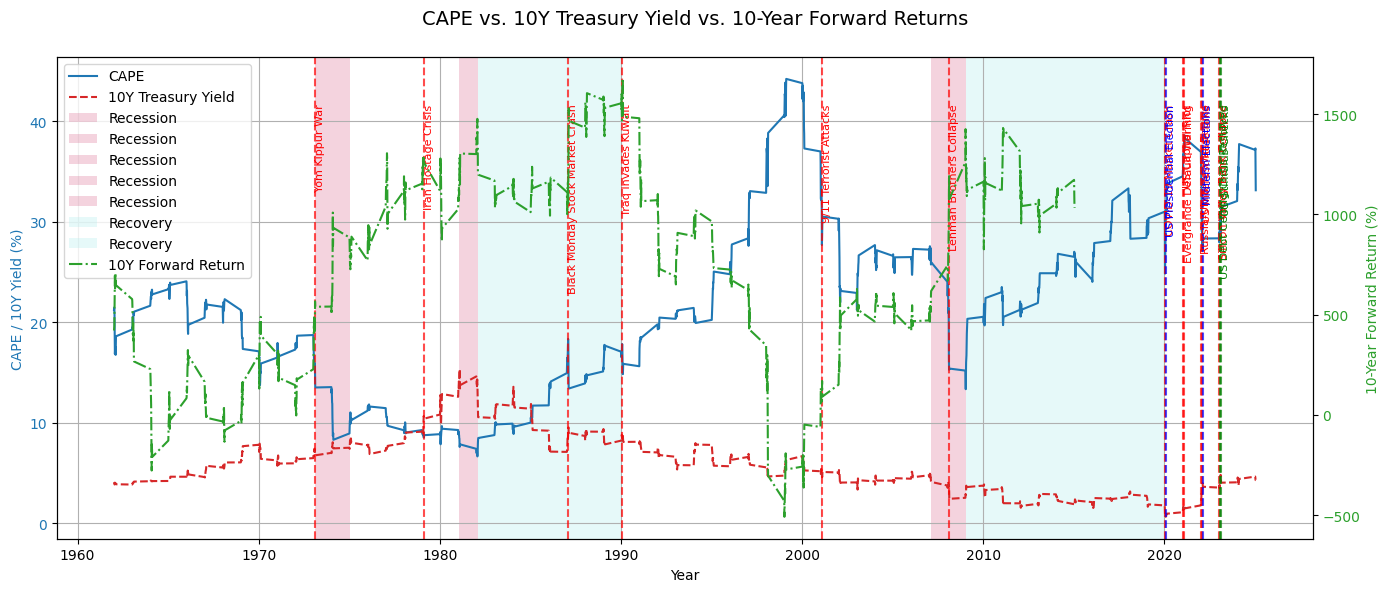

In [66]:
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot CAPE
color1 = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('CAPE / 10Y Yield (%)', color=color1)
ax1.plot(new_merged_df.index, new_merged_df['CAPE'], color=color1, label='CAPE')
ax1.plot(new_merged_df.index, new_merged_df['10Y_Yield'], color='tab:red', linestyle='--', label='10Y Treasury Yield')
ax1.tick_params(axis='y', labelcolor=color1)
# Add recession rectangles
for start, end in recession_periods:
    ax1.axvspan(start, end, facecolor='palevioletred', alpha=0.3, label='Recession')

# Add recovery rectangles
for start, end in recovery_periods:
    ax1.axvspan(start, end, facecolor='paleturquoise', alpha=0.3, label='Recovery')


# Add events to the plot
for date, event, color in events:
    ax1.axvline(x=date, color=color, linestyle='--', alpha=0.7)
    ax1.text(date, ax1.get_ylim()[1] * 0.9, event, rotation=90, verticalalignment='top', color=color, fontsize=8)

# Secondary Y-axis for forward returns
ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('10-Year Forward Return (%)', color=color2)
ax2.plot(new_merged_df.index, new_merged_df['10Y_Forward_Return'] * 100, color=color2, linestyle='-.', label='10Y Forward Return')
ax2.tick_params(axis='y', labelcolor=color2)
# Titles and Legends
fig.suptitle('CAPE vs. 10Y Treasury Yield vs. 10-Year Forward Returns', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=0.9)
ax1.grid(True)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()
